In [1]:
import io
import os
import random
import shutil
import itertools
import numpy as np
import sklearn.metrics
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from datetime import datetime
from shutil import copyfile
from os import getcwd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Making Empty Folder in Drive

In [2]:
root_dir = '/content/drive/MyDrive/ML/New_Dataset_test'

if os.path.exists(root_dir):
  shutil.rmtree(root_dir)

def create_train_val_dirs(root_path):
  train_dir = os.path.join(root_path, 'training')
  validation_dir = os.path.join(root_path, 'validation')


  train_busuk_dir = os.path.join(train_dir, 'busuk')
  # train_kurang_segar_dir = os.path.join(train_dir, 'kurang_segar')
  train_segar_dir = os.path.join(train_dir, 'segar')
  os.makedirs(train_busuk_dir)
  # os.makedirs(train_kurang_segar_dir)
  os.makedirs(train_segar_dir)

  
  validation_busuk_dir = os.path.join(validation_dir, 'busuk')
  # validation_kurang_segar_dir = os.path.join(validation_dir, 'kurang_segar')
  validation_segar_dir = os.path.join(validation_dir, 'segar')
  os.makedirs(validation_busuk_dir)
  # os.makedirs(validation_kurang_segar_dir)
  os.makedirs(validation_segar_dir)

try:
  create_train_val_dirs(root_path=root_dir)
except FileExistsError:
  print("You should not be seeing this since the upper directory is removed beforehand")

In [3]:
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, SPLIT_SIZE):
  files = os.listdir(SOURCE_DIR)

  split = (len(files)*SPLIT_SIZE)

  #Randomize the file sample
  files = random.sample(files, len(files))

  train = files[:int(split)]
    
  
  for name in train:
    source = os.path.join(SOURCE_DIR, name)
    destination = os.path.join(TRAINING_DIR, name)
    if os.path.getsize(source)>0:
      copyfile(source, destination) 
    else:
      print(f"{name} is zero length, so ignoring.")


  valid = files[int(split):]
  
  for name in valid:
    source = os.path.join(SOURCE_DIR, name)
    destination = os.path.join(VALIDATION_DIR, name)
    if os.path.getsize(source)>0:
      copyfile(source, destination) 
    else:
      print(f"{name} is zero length, so ignoring.")

#### Split and add the images

In [4]:
# Define paths
SEGAR_DIR = "/content/drive/MyDrive/ML/New_Dataset/segar"
# KURANG_SEGAR_DIR = "/content/drive/MyDrive/ML/Dataset/Gills (1)/kurang-segar"
BUSUK_DIR = "/content/drive/MyDrive/ML/New_Dataset/busuk"

TRAINING_DIR = "/content/drive/MyDrive/ML/New_Dataset_test/training"
VALIDATION_DIR = "/content/drive/MyDrive/ML/New_Dataset_test/validation"

TRAINING_SEGAR_DIR = os.path.join(TRAINING_DIR, "segar/")
VALIDATION_SEGAR_DIR = os.path.join(VALIDATION_DIR, "segar/")
# TRAINING_KURANG_SEGAR_DIR = os.path.join(TRAINING_DIR, "kurang_segar/")
# VALIDATION_KURANG_SEGAR_DIR = os.path.join(VALIDATION_DIR, "kurang_segar/")

TRAINING_BUSUK_DIR = os.path.join(TRAINING_DIR, "busuk/")
VALIDATION_BUSUK_DIR = os.path.join(VALIDATION_DIR, "busuk/")

# Empty directories in case you run this cell multiple times
if len(os.listdir(TRAINING_SEGAR_DIR)) > 0:
  for file in os.scandir(TRAINING_SEGAR_DIR):
    os.remove(file.path)
# if len(os.listdir(TRAINING_KURANG_SEGAR_DIR)) > 0:
#   for file in os.scandir(TRAINING_KURANG_SEGAR_DIR):
#     os.remove(file.path)
if len(os.listdir(TRAINING_BUSUK_DIR)) > 0:
  for file in os.scandir(TRAINING_BUSUK_DIR):
    os.remove(file.path)
if len(os.listdir(VALIDATION_SEGAR_DIR)) > 0:
  for file in os.scandir(VALIDATION_SEGAR_DIR):
    os.remove(file.path)
# if len(os.listdir(VALIDATION_KURANG_SEGAR_DIR)) > 0:
#   for file in os.scandir(VALIDATION_KURANG_SEGAR_DIR):
#     os.remove(file.path)
if len(os.listdir(VALIDATION_BUSUK_DIR)) > 0:
  for file in os.scandir(VALIDATION_BUSUK_DIR):
    os.remove(file.path)

# Define proportion of images used for training
split_size = .7

# Run the function
# NOTE: Messages about zero length images should be printed out
split_data(SEGAR_DIR, TRAINING_SEGAR_DIR, VALIDATION_SEGAR_DIR, split_size)
# split_data(KURANG_SEGAR_DIR, TRAINING_KURANG_SEGAR_DIR, VALIDATION_KURANG_SEGAR_DIR, split_size)
split_data(BUSUK_DIR, TRAINING_BUSUK_DIR, VALIDATION_BUSUK_DIR, split_size)

# Your function should perform copies rather than moving images so original directories should contain unchanged images
print(f"Original fresh directory has {len(os.listdir(SEGAR_DIR))} images")
# print(f"Original less_fresh directory has {len(os.listdir(KURANG_SEGAR_DIR))} images")
print(f"Original spoiled directory has {len(os.listdir(BUSUK_DIR))} images\n")

# Training and validation splits. Check that the number of images matches the expected output.
print(f"There are {len(os.listdir(TRAINING_SEGAR_DIR))} images of fresh fish for training")
print(f"There are {len(os.listdir(VALIDATION_SEGAR_DIR))} images of fresh fish for validation")
# print(f"There are {len(os.listdir(TRAINING_KURANG_SEGAR_DIR))} images of less fresh fish for training")
# print(f"There are {len(os.listdir(VALIDATION_KURANG_SEGAR_DIR))} images of less fresh fish for validation")
print(f"There are {len(os.listdir(TRAINING_BUSUK_DIR))} images of spoiled fish for training")
print(f"There are {len(os.listdir(VALIDATION_BUSUK_DIR))} images of spoiled fish for validation")

Original fresh directory has 60 images
Original spoiled directory has 59 images

There are 42 images of fresh fish for training
There are 18 images of fresh fish for validation
There are 41 images of spoiled fish for training
There are 18 images of spoiled fish for validation


In [5]:
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale=1.0/225,
                                     horizontal_flip=True,
                                     fill_mode="nearest")

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                      batch_size=20,
                                                      class_mode="categorical",
                                                      target_size=(150,150))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale=1.0/225)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=20,
                                                                class_mode="categorical",
                                                                target_size=(150,150))
  return train_generator, validation_generator

In [6]:
train_generator, validation_generator = train_val_generators(TRAINING_DIR, VALIDATION_DIR)

Found 83 images belonging to 2 classes.
Found 36 images belonging to 2 classes.


In [7]:
# Build the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation=tf.nn.relu,input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if(logs.get("accuracy")>0.96 or logs.get("val_accuracy")>0.96):
      print("stop train!")
      self.model.stop_training=True

In [9]:
callbacks = myCallback()
# Train the model
# Note that this may take some time.
history = model.fit(train_generator,epochs=25,verbose=1,validation_data=validation_generator,callbacks=[callbacks])

Epoch 1/25
5/5 [==============================] - 29s 6s/step - loss: 3.6579 - accuracy: 0.4699 - val_loss: 2.0454 - val_accuracy: 0.5000
Epoch 2/25
5/5 [==============================] - 17s 3s/step - loss: 1.1453 - accuracy: 0.6145 - val_loss: 0.6564 - val_accuracy: 0.5000
Epoch 3/25
5/5 [==============================] - 21s 4s/step - loss: 0.6357 - accuracy: 0.6024 - val_loss: 0.5840 - val_accuracy: 0.7778
Epoch 4/25
5/5 [==============================] - 18s 4s/step - loss: 0.5026 - accuracy: 0.8313 - val_loss: 0.4337 - val_accuracy: 0.7222
Epoch 5/25
5/5 [==============================] - 17s 4s/step - loss: 0.3499 - accuracy: 0.8193 - val_loss: 0.4547 - val_accuracy: 0.7222
Epoch 6/25
5/5 [==============================] - 17s 3s/step - loss: 0.4442 - accuracy: 0.7952 - val_loss: 0.4269 - val_accuracy: 0.8333
Epoch 7/25
5/5 [==============================] - 17s 4s/step - loss: 0.3063 - accuracy: 0.9157 - val_loss: 0.3712 - val_accuracy: 0.8333
Epoch 8/25
5/5 [==================

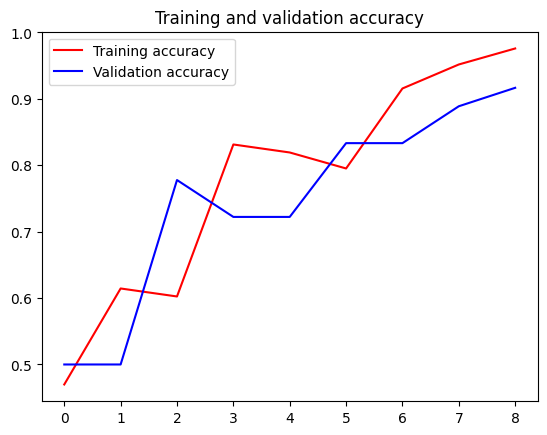

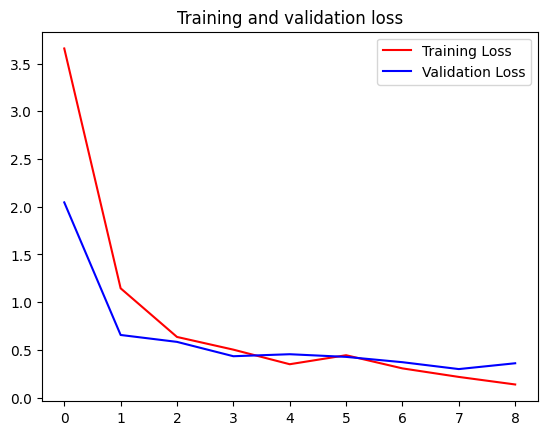

In [10]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Saving mata_s2.png to mata_s2.png


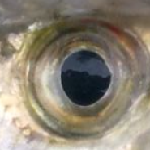

1/1 [==============================] - 0s 150ms/step
[[0.9594322  0.04056788]]


In [11]:
import numpy as np

from google.colab import files
from tensorflow.keras.utils import load_img, img_to_array

uploaded=files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path='/content/' + fn
  img=load_img(path, target_size=(150, 150))

  img.show()
  
  x=img_to_array(img)
  x /= 255
  x=np.expand_dims(x, axis=0)
  images = np.vstack([x])

  classes = model.predict(images)

  print(classes)